# Data processing for vineyard

**Vineyard index scales**

| Índices                             | Clases            | Rango de valores | Clases ID         |
|-------------------------------------|-------------------|------------------|-------------------|
|**Índice Huglin o Heliotérmico (HI)**| Muy cálido        | HI > 3000        | HI+3              |
|                                     | Cálido            | 2400 < HI ≤ 3000 | HI+2              |
|                                     | Templado cálido   | 2100 < HI ≤ 2400 | HI+1              |
|                                     | Templado          | 1800 < HI ≤ 2100 | HI-1              |
|                                     | Fresco            | 1500 < HI ≤ 1800 | HI-2              |
|                                     | Muy Fresco        | HI ≤ 1500        | HI-3              |
|                                     |                   |                  |                   |                   
|**Índice de Frescor Nocturno(CI)**   | Muy fresco        | CI ≤ 12          | CI+2              |
|                                     | Fresco            | 12 < CI ≤ 14     | CI+1              |
|                                     | Templado          | 14 < CI ≤ 18     | CI-1              |
|                                     | Cálido            | CI > 18          | CI-2              |
|                                     |                   |                  |                   |
|**Índice de Sequía (DI)**            | Muy seco          | DI ≤-200         | DI+3              |
|                                     | Seco              | -200 < DI ≤ -100 | DI+2              |
|                                     | Moderadamente seco| -100 < DI ≤ 50   | DI+1              |
|                                     | Sub húmedo        | 50 < DI ≤150     | DI-1              |
|                                     | Húmedo            | DI > 150         | DI-2              |

**ZONA DE ALTO POTENCIAL VITÍCOLA:**
- **Índice de Huglin**: clases de clima muy fresco (HI-3), fresco (HI-2), templado (HI-1) y clase de clima templado cálido (HI+1).
- **Índice de Frescor Nocturno**: clases de clima con noches frescas (CI+1) y muy frescas (CI+2).
- **Índice de Sequía**: clases de clima sub-húmedo (DI-1) y moderadamente seco (DI+1).

**scenarios' equivalences**

RCPs and SSPs, resulting in four suggestions of suitable combinations, mapping: 
- (i) A2 world onto RCP 8.5 and SSP3
- (ii) B2 (or A1B) world onto RCP 6.0 and SSP2
- (iii) B1 world onto RCP 4.5 and SSP1
- (iv) A1FI world onto RCP 8.5 and SSP5

# Setup
## Library import
We import all the required Python libraries

In [6]:
import fiona
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import box
from tqdm import tqdm

# Data import

In [7]:
## Spain
spain = gpd.read_file('../../datasets/processed/spain.geojson', driver='GeoJSON')

<AxesSubplot:>

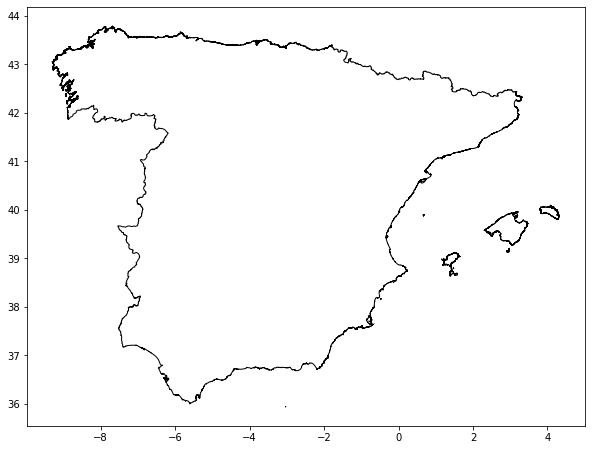

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
spain.plot(ax=ax, color='w', edgecolor='k')

## Frescor Nocturno 
**Read data**

In [9]:
layerlist = fiona.listlayers('../../datasets/raw/crops/vino/Resumen FRESCOR.dbf')
layerlist

['Resumen FRESCOR']

In [10]:
df_frescor = gpd.read_file('../../datasets/raw/crops/vino/Resumen FRESCOR.dbf', driver="FileDBF", layer=layerlist[0])
df_frescor = df_frescor[['DENOMINACI', 'LONG', 'LAT', 'ALTURA', 'N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1', 'geometry']]
df_frescor

,DENOMINACI,LONG,LAT,ALTURA,N1971_2000,MEDIA,A1B,A2,B1,geometry
0,1.0,-5.6,36.0,228.93,19.00,20.26,20.37,20.10,20.14,None
1,2.0,-5.4,36.0,143.71,18.92,20.15,20.26,19.99,20.03,None
2,3.0,-6.0,36.2,62.26,19.95,21.31,21.44,21.09,21.17,None
3,4.0,-5.8,36.2,75.97,19.14,20.48,20.60,20.26,20.35,None
4,5.0,-5.6,36.2,270.90,18.01,19.26,19.38,19.08,19.11,None
...,...,...,...,...,...,...,...,...,...,...
1440,1441.0,-5.4,43.6,114.55,14.62,15.97,16.10,15.94,15.73,None
1441,1442.0,-5.2,43.6,41.89,14.75,16.14,16.29,16.06,15.86,None
1442,1443.0,-8.0,43.8,275.28,12.96,14.08,14.20,14.01,13.86,None
1443,1444.0,-7.8,43.8,88.86,12.78,13.89,14.01,13.81,13.68,None


**Create grid**

In [11]:
gdf_frescor = gpd.GeoDataFrame(df_frescor, geometry=gpd.points_from_xy(df_frescor.LONG, df_frescor.LAT))
gdf_frescor = gdf_frescor.set_crs("EPSG:4326")

In [12]:
# total area for the grid
xmin, ymin, xmax, ymax= gdf_frescor.total_bounds
# how many cells across and down
n_cells=gdf_frescor['LONG'].nunique()
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "EPSG:4326"#"+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(box(x0+cell_size*0.5, y0-cell_size*0.5, x1+cell_size*0.5, y1-cell_size*0.5)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

<AxesSubplot:>

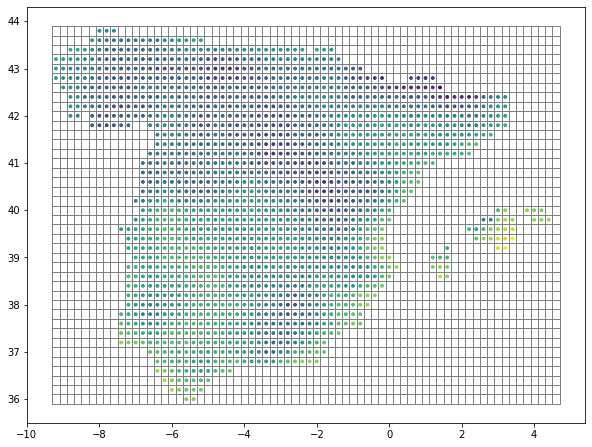

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
gdf_frescor.plot(ax=ax, column='MEDIA', markersize=8)

**Intersect points with grid**

In [14]:
polygons = []
sindex = cell.sindex
# Iterate over the geometries
for n, geometry in enumerate(tqdm(gdf_frescor.geometry)):

    # Find approximate matches with r-tree
    possible_matches_index = list(sindex.intersection(geometry.bounds))
    possible_matches = cell.iloc[possible_matches_index]
    # Find precise matches with r-tree
    polygons.append(possible_matches[possible_matches.intersects(geometry)]['geometry'].iloc[0])

100%|██████████| 1445/1445 [00:01<00:00, 997.87it/s] 


In [15]:
gdf_frescor['geometry'] = polygons

<AxesSubplot:>

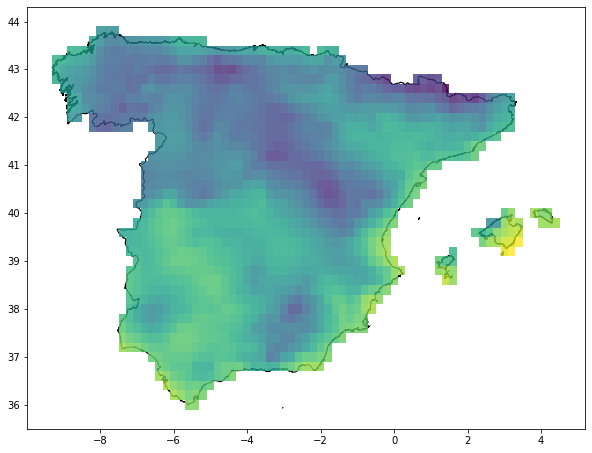

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
spain.plot(ax=ax, color='w', edgecolor='k')
gdf_frescor.plot(ax=ax, column='MEDIA', alpha=0.8)

**Intersect grid with spain**

In [17]:
gdf_frescor = gdf_frescor.overlay(gpd.GeoDataFrame({'geometry':spain.simplify(0.005)}), how='intersection')

<AxesSubplot:>

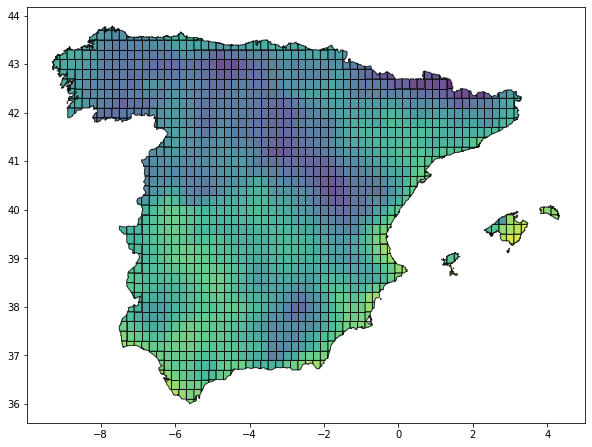

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_frescor.plot(ax=ax, column='MEDIA', alpha=0.8, edgecolor='k')

**Save grid as GeoJSON**

In [59]:
gdf_grid = gdf_frescor[['DENOMINACI', 'LONG', 'LAT', 'geometry']]

In [62]:
gdf_grid.to_file('../../datasets/processed/rejilla_viñedos.geojson', driver='GeoJSON')  

<AxesSubplot:>

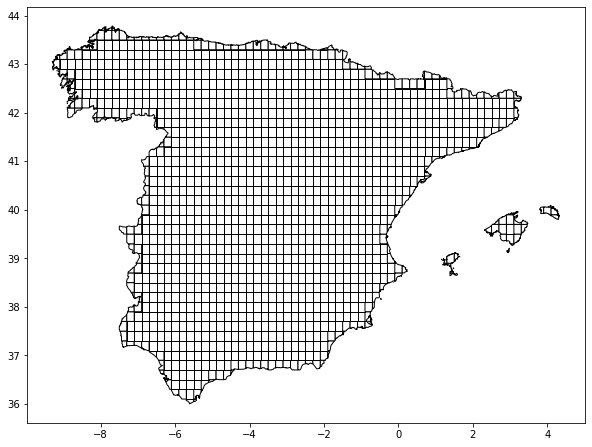

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_grid.plot(ax=ax, color='w', edgecolor='k')

### Add index classes

| Índices                             | Clases            | Rango de valores | Clases ID         |
|-------------------------------------|-------------------|------------------|-------------------|                 
|**Índice de Frescor Nocturno(CI)**   | Muy fresco        | CI ≤ 12          | CI+2              |
|                                     | Fresco            | 12 < CI ≤ 14     | CI+1              |
|                                     | Templado          | 14 < CI ≤ 18     | CI-1              |
|                                     | Cálido            | CI > 18          | CI-2              |

In [19]:
def CI_index_classes(x):
    if x <= 12:
        return 'CI+2'
    if (x > 12) and (x <= 14):
        return 'CI+1'
    if (x > 14) and (x <= 18):
        return 'CI-1'
    if x > 18:
        return 'CI-2'

In [20]:
for scenario in ['N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1']:
    print(scenario)
    gdf_frescor[f'{scenario}_class'] = gdf_frescor[scenario].apply(lambda x: CI_index_classes(x))

N1971_2000
MEDIA
A1B
A2
B1


<AxesSubplot:>

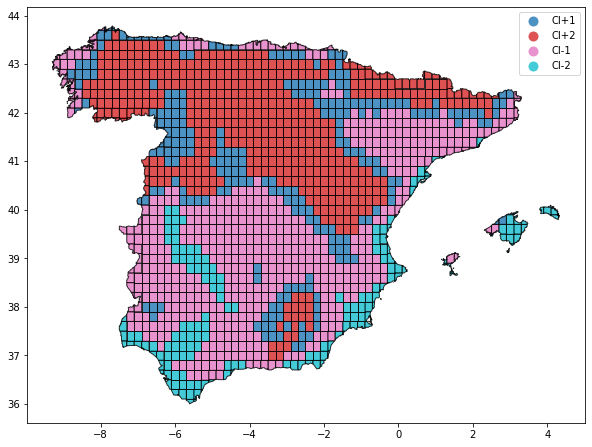

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_frescor.plot(ax=ax, column='MEDIA_class', alpha=0.8, edgecolor='k', legend=True)

## Huglin 
**Read data**

In [22]:
layerlist = fiona.listlayers('../../datasets/raw/crops/vino/Resumen Huglin.dbf')
layerlist

['Resumen Huglin']

In [23]:
df_huglin = gpd.read_file('../../datasets/raw/crops/vino/Resumen Huglin.dbf', driver="FileDBF", layer=layerlist[0])
df_huglin = df_huglin[['DENOMINACI', 'LONG', 'LAT', 'ALTURA', 'N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1', 'geometry']]
df_huglin

,DENOMINACI,LONG,LAT,ALTURA,N1971_2000,MEDIA,A1B,A2,B1,geometry
0,1.0,-5.6,36.0,228.93,2079.05,2306.05,2322.15,2211.63,2327.29,None
1,2.0,-5.4,36.0,143.71,2150.34,2376.45,2392.96,2286.38,2394.18,None
2,3.0,-6.0,36.2,62.26,2317.59,2565.03,2585.36,2458.09,2584.47,None
3,4.0,-5.8,36.2,75.97,2341.20,2586.96,2607.63,2480.11,2605.60,None
4,5.0,-5.6,36.2,270.90,2166.85,2397.34,2419.70,2293.55,2410.43,None
...,...,...,...,...,...,...,...,...,...,...
1440,1441.0,-5.4,43.6,114.55,1482.62,1693.18,1698.11,1645.05,1711.21,None
1441,1442.0,-5.2,43.6,41.89,1595.80,1802.61,1807.50,1757.12,1819.15,None
1442,1443.0,-8.0,43.8,275.28,1237.81,1404.75,1409.99,1369.06,1414.63,None
1443,1444.0,-7.8,43.8,88.86,1434.68,1604.90,1611.24,1564.11,1615.43,None


**Create grid**

In [24]:
gdf_huglin = gpd.GeoDataFrame(df_huglin, geometry=gpd.points_from_xy(df_huglin.LONG, df_huglin.LAT))
gdf_huglin = gdf_huglin.set_crs("EPSG:4326")

In [25]:
gdf_huglin['geometry'] = polygons

<AxesSubplot:>

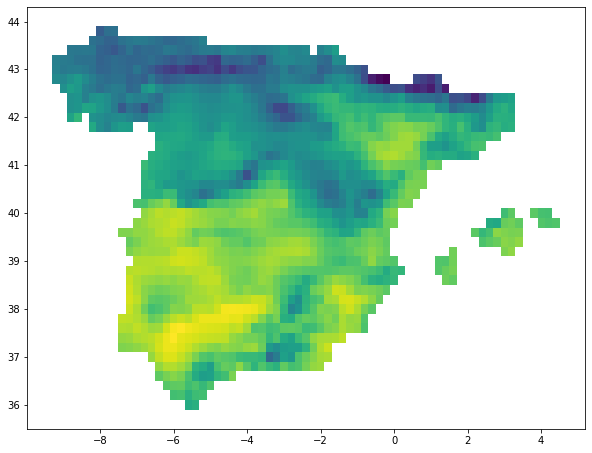

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_huglin.plot(ax=ax, column='MEDIA')

**Intersect grid with spain**

In [27]:
gdf_huglin = gdf_huglin.overlay(gpd.GeoDataFrame({'geometry':spain.simplify(0.005)}), how='intersection')

<AxesSubplot:>

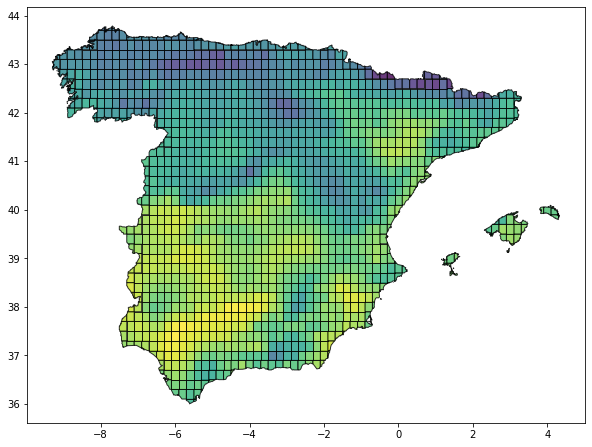

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_huglin.plot(ax=ax, column='MEDIA', alpha=0.8, edgecolor='k')

### Add index classes

| Índices                             | Clases            | Rango de valores | Clases ID         |
|-------------------------------------|-------------------|------------------|-------------------|
|**Índice Huglin o Heliotérmico (HI)**| Muy cálido        | HI > 3000        | HI+3              |
|                                     | Cálido            | 2400 < HI ≤ 3000 | HI+2              |
|                                     | Templado cálido   | 2100 < HI ≤ 2400 | HI+1              |
|                                     | Templado          | 1800 < HI ≤ 2100 | HI-1              |
|                                     | Fresco            | 1500 < HI ≤ 1800 | HI-2              |
|                                     | Muy Fresco        | HI ≤ 1500        | HI-3              |

In [29]:
def HI_index_classes(x):
    if x > 3000:
        return 'HI+3'
    if (x > 2400) and (x <= 3000):
        return 'HI+2'
    if (x > 2100) and (x <= 2400):
        return 'HI+1'
    if (x > 1800) and (x <= 2100):
        return 'HI-1'
    if (x > 1500) and (x <= 1800):
        return 'HI-2'
    if x <= 1500:
        return 'HI-3'

In [30]:
for scenario in ['N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1']:
    print(scenario)
    gdf_huglin[f'{scenario}_class'] = gdf_huglin[scenario].apply(lambda x: HI_index_classes(x))

N1971_2000
MEDIA
A1B
A2
B1


<AxesSubplot:>

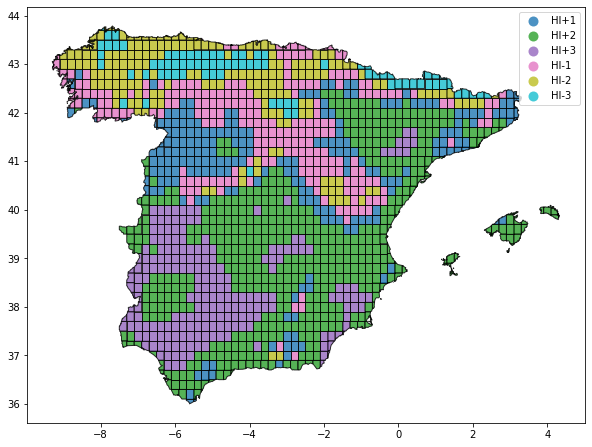

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_huglin.plot(ax=ax, column='MEDIA_class', alpha=0.8, edgecolor='k', legend=True)

## Sequía
**Read data**

In [32]:
layerlist = fiona.listlayers('../../datasets/raw/crops/vino/Resumen IS.dbf')
layerlist

['Resumen IS']

In [33]:
df_is = gpd.read_file('../../datasets/raw/crops/vino/Resumen IS.dbf', driver="FileDBF", layer=layerlist[0])
df_is = df_is[['DENOMINACI', 'LONG', 'LAT', 'ALTURA', 'N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1', 'geometry']]
df_is

,DENOMINACI,LONG,LAT,ALTURA,N1971_2000,MEDIA,A1B,A2,B1,geometry
0,1.0,-5.6,36.0,228.93,47.67,20.20,12.39,30.17,31.40,None
1,2.0,-5.4,36.0,143.71,47.32,2.60,-5.18,9.81,15.39,None
2,3.0,-6.0,36.2,62.26,44.07,4.21,-4.62,17.79,15.49,None
3,4.0,-5.8,36.2,75.97,28.97,-16.17,-24.62,-1.73,-6.22,None
4,5.0,-5.6,36.2,270.90,51.98,0.90,-8.46,14.43,13.37,None
...,...,...,...,...,...,...,...,...,...,...
1440,1441.0,-5.4,43.6,114.55,257.09,196.37,192.64,211.83,195.27,None
1441,1442.0,-5.2,43.6,41.89,255.20,192.25,187.25,211.48,191.73,None
1442,1443.0,-8.0,43.8,275.28,350.15,289.40,287.32,295.82,290.13,None
1443,1444.0,-7.8,43.8,88.86,260.76,198.40,195.89,204.78,200.10,None


**Create gridd**

In [34]:
gdf_is = gpd.GeoDataFrame(df_is, geometry=gpd.points_from_xy(df_is.LONG, df_is.LAT))
gdf_is = gdf_is.set_crs("EPSG:4326")

In [35]:
gdf_is['geometry'] = polygons

<AxesSubplot:>

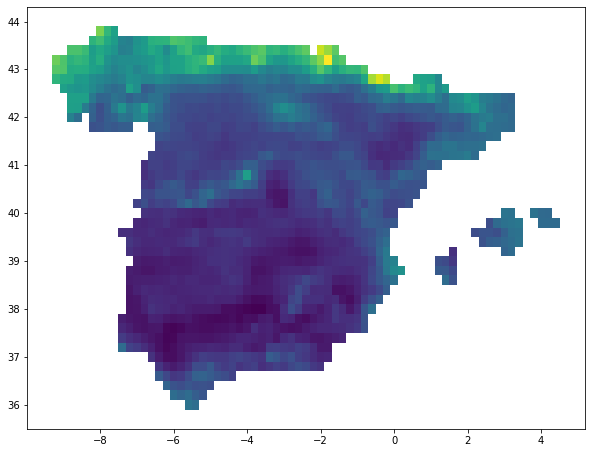

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_is.plot(ax=ax, column='MEDIA')

**Intersect grid with spain**

In [37]:
gdf_is = gdf_is.overlay(gpd.GeoDataFrame({'geometry':spain.simplify(0.005)}), how='intersection')

<AxesSubplot:>

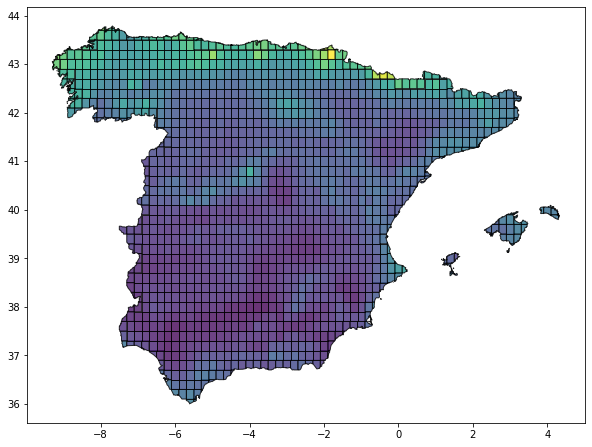

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_is.plot(ax=ax, column='MEDIA', alpha=0.8, edgecolor='k')

### Add index classes

| Índices                             | Clases            | Rango de valores | Clases ID         |
|-------------------------------------|-------------------|------------------|-------------------|
|**Índice de Sequía (DI)**            | Muy seco          | DI ≤-200         | DI+3              |
|                                     | Seco              | -200 < DI ≤ -100 | DI+2              |
|                                     | Moderadamente seco| -100 < DI ≤ 50   | DI+1              |
|                                     | Sub húmedo        | 50 < DI ≤150     | DI-1              |
|                                     | Húmedo            | DI > 150         | DI-2              |

In [39]:
def DI_index_classes(x):
    if x <= -200:
        return 'DI+3'
    if (x > -200) and (x <= -100):
        return 'DI+2'
    if (x > -100) and (x <= 50):
        return 'DI+1'
    if (x > 50) and (x <= 150):
        return 'DI-1'
    if x > 150:
        return 'DI-2'

In [40]:
for scenario in ['N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1']:
    print(scenario)
    gdf_is[f'{scenario}_class'] = gdf_is[scenario].apply(lambda x: DI_index_classes(x))

N1971_2000
MEDIA
A1B
A2
B1


<AxesSubplot:>

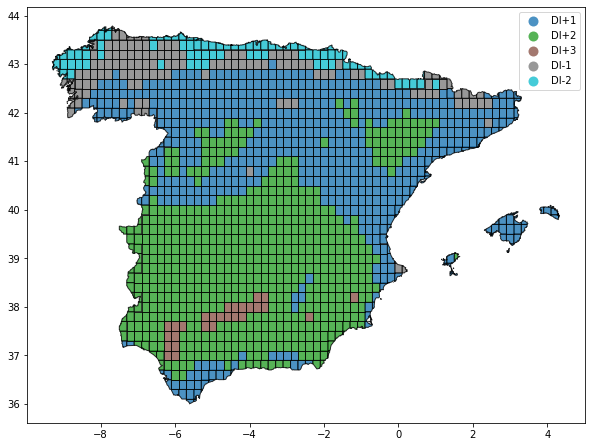

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_is.plot(ax=ax, column='MEDIA_class', alpha=0.8, edgecolor='k', legend=True)

## Mapa de zonificación

In [42]:
lst = list(gdf_is[['N1971_2000_class', 'MEDIA_class', 'A1B_class','A2_class', 'B1_class']].columns)
lst_z = [x.replace('class', 'class_z') for x in lst]

gdf_is_z = gdf_is[['LONG', 'LAT', 'N1971_2000_class', 'MEDIA_class', 'A1B_class','A2_class', 'B1_class']].rename(columns=dict(zip(lst,lst_z)))

In [43]:
gdf_is_z

,LONG,LAT,N1971_2000_class_z,MEDIA_class_z,A1B_class_z,A2_class_z,B1_class_z
0,-5.6,36.0,DI+1,DI+1,DI+1,DI+1,DI+1
1,-5.4,36.0,DI+1,DI+1,DI+1,DI+1,DI+1
2,-6.0,36.2,DI+1,DI+1,DI+1,DI+1,DI+1
3,-5.8,36.2,DI+1,DI+1,DI+1,DI+1,DI+1
4,-5.6,36.2,DI-1,DI+1,DI+1,DI+1,DI+1
...,...,...,...,...,...,...,...
1437,-5.4,43.6,DI-2,DI-2,DI-2,DI-2,DI-2
1438,-5.2,43.6,DI-2,DI-2,DI-2,DI-2,DI-2
1439,-8.0,43.8,DI-2,DI-2,DI-2,DI-2,DI-2
1440,-7.8,43.8,DI-2,DI-2,DI-2,DI-2,DI-2


In [44]:
gdf_zone = pd.merge(pd.merge(gdf_frescor[['DENOMINACI', 'LONG', 'LAT', 'geometry', 'N1971_2000_class', 'MEDIA_class', 'A1B_class',
           'A2_class', 'B1_class']], gdf_huglin[['LONG', 'LAT', 'N1971_2000_class', 'MEDIA_class', 'A1B_class',
           'A2_class', 'B1_class']], how='left', on=['LONG', 'LAT']),\
             gdf_is_z[['LONG', 'LAT', 'N1971_2000_class_z', 'MEDIA_class_z', 'A1B_class_z',
           'A2_class_z', 'B1_class_z']], how='left', on=['LONG', 'LAT'])

In [45]:
lst = list(gdf_zone.columns)
lst_new = [x.replace('class_x', 'class_CI') for x in lst]
lst_new = [x.replace('class_y', 'class_HI') for x in lst_new]
lst_new = [x.replace('class_z', 'class_DI') for x in lst_new]

In [46]:
gdf_zone = gdf_zone.rename(columns=dict(zip(lst,lst_new)))

In [47]:
gdf_zone.head()

,DENOMINACI,LONG,LAT,geometry,N1971_2000_class_CI,MEDIA_class_CI,A1B_class_CI,A2_class_CI,B1_class_CI,N1971_2000_class_HI,MEDIA_class_HI,A1B_class_HI,A2_class_HI,B1_class_HI,N1971_2000_class_DI,MEDIA_class_DI,A1B_class_DI,A2_class_DI,B1_class_DI
0,1.0,-5.6,36.0,"POLYGON ((-5.70000 36.06555, -5.70000 36.10000...",CI-2,CI-2,CI-2,CI-2,CI-2,HI-1,HI+1,HI+1,HI+1,HI+1,DI+1,DI+1,DI+1,DI+1,DI+1
1,2.0,-5.4,36.0,"POLYGON ((-5.50000 36.04849, -5.50000 36.10000...",CI-2,CI-2,CI-2,CI-2,CI-2,HI+1,HI+1,HI+1,HI+1,HI+1,DI+1,DI+1,DI+1,DI+1,DI+1
2,3.0,-6.0,36.2,"POLYGON ((-6.10000 36.28086, -6.10000 36.30000...",CI-2,CI-2,CI-2,CI-2,CI-2,HI+1,HI+2,HI+2,HI+2,HI+2,DI+1,DI+1,DI+1,DI+1,DI+1
3,4.0,-5.8,36.2,"POLYGON ((-5.90000 36.17463, -5.90000 36.30000...",CI-2,CI-2,CI-2,CI-2,CI-2,HI+1,HI+2,HI+2,HI+2,HI+2,DI+1,DI+1,DI+1,DI+1,DI+1
4,5.0,-5.6,36.2,"POLYGON ((-5.70000 36.10000, -5.70000 36.30000...",CI-2,CI-2,CI-2,CI-2,CI-2,HI+1,HI+1,HI+2,HI+1,HI+2,DI-1,DI+1,DI+1,DI+1,DI+1


In [48]:
def combine_indexes_class(x, scenario):
    if (x[f'{scenario}_class_DI'] == 'DI-1') and  (x[f'{scenario}_class_CI'] == 'CI+2') and (x[f'{scenario}_class_HI'] == 'HI-3'):
        return 'DI-1, CI+2, HI-3'
    if (x[f'{scenario}_class_DI'] == 'DI-1') and  (x[f'{scenario}_class_CI'] == 'CI+2') and (x[f'{scenario}_class_HI'] == 'HI-2'):
        return 'DI-1, CI+2, HI-2'
    if (x[f'{scenario}_class_DI'] == 'DI-1') and  (x[f'{scenario}_class_CI'] == 'CI+1') and (x[f'{scenario}_class_HI'] == 'HI-3'):
        return 'DI-1, CI+1, HI-3'
    if (x[f'{scenario}_class_DI'] == 'DI-1') and  (x[f'{scenario}_class_CI'] == 'CI+1') and (x[f'{scenario}_class_HI'] == 'HI-2'):
        return 'DI-1, CI+1, HI-2'
    if (x[f'{scenario}_class_DI'] == 'DI-1') and  (x[f'{scenario}_class_CI'] == 'CI+1') and (x[f'{scenario}_class_HI'] == 'HI-1'):
        return 'DI-1, CI+1, HI-1'
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+2') and (x[f'{scenario}_class_HI'] == 'HI-3'):
        return 'DI+1, CI+2, HI-3'
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+2') and (x[f'{scenario}_class_HI'] == 'HI-2'):
        return 'DI+1, CI+2, HI-2'
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+2') and (x[f'{scenario}_class_HI'] == 'HI-1'):
        return 'DI+1, CI+2, HI-1'
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+2') and (x[f'{scenario}_class_HI'] == 'HI+1'):
        return 'DI+1, CI+2, HI+1'
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+1') and (x[f'{scenario}_class_HI'] == 'HI-2'):
        return 'DI+1, CI+1, HI-2'
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+1') and (x[f'{scenario}_class_HI'] == 'HI-1'):
        return 'DI+1, CI+1, HI-1'
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+1') and (x[f'{scenario}_class_HI'] == 'HI+1'):
        return 'DI+1, CI+1, HI+1'
    return ''

In [49]:
def combine_indexes_value(x, scenario):
    if (x[f'{scenario}_class_DI'] == 'DI-1') and  (x[f'{scenario}_class_CI'] == 'CI+2') and (x[f'{scenario}_class_HI'] == 'HI-3'):
        return 1
    if (x[f'{scenario}_class_DI'] == 'DI-1') and  (x[f'{scenario}_class_CI'] == 'CI+2') and (x[f'{scenario}_class_HI'] == 'HI-2'):
        return 2
    if (x[f'{scenario}_class_DI'] == 'DI-1') and  (x[f'{scenario}_class_CI'] == 'CI+1') and (x[f'{scenario}_class_HI'] == 'HI-3'):
        return 3
    if (x[f'{scenario}_class_DI'] == 'DI-1') and  (x[f'{scenario}_class_CI'] == 'CI+1') and (x[f'{scenario}_class_HI'] == 'HI-2'):
        return 4
    if (x[f'{scenario}_class_DI'] == 'DI-1') and  (x[f'{scenario}_class_CI'] == 'CI+1') and (x[f'{scenario}_class_HI'] == 'HI-1'):
        return 5
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+2') and (x[f'{scenario}_class_HI'] == 'HI-3'):
        return 6
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+2') and (x[f'{scenario}_class_HI'] == 'HI-2'):
        return 7
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+2') and (x[f'{scenario}_class_HI'] == 'HI-1'):
        return 8
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+2') and (x[f'{scenario}_class_HI'] == 'HI+1'):
        return 9
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+1') and (x[f'{scenario}_class_HI'] == 'HI-2'):
        return 10
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+1') and (x[f'{scenario}_class_HI'] == 'HI-1'):
        return 11
    if (x[f'{scenario}_class_DI'] == 'DI+1') and  (x[f'{scenario}_class_CI'] == 'CI+1') and (x[f'{scenario}_class_HI'] == 'HI+1'):
        return 12
    return np.nan

In [50]:
for scenario in ['N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1']:
    print(scenario)
    gdf_zone[f'{scenario}_class'] = gdf_zone.apply(lambda x: combine_indexes_class(x, scenario), axis=1)
    gdf_zone[f'{scenario}'] = gdf_zone.apply(lambda x: combine_indexes_value(x, scenario), axis=1)

N1971_2000
MEDIA
A1B
A2
B1


In [51]:
gdf_zone = gdf_zone[['DENOMINACI', 'LONG', 'LAT', 'geometry', 'N1971_2000_class', 'N1971_2000',
       'MEDIA_class', 'MEDIA', 'A1B_class', 'A1B', 'A2_class', 'A2',
       'B1_class', 'B1']]
gdf_zone

,DENOMINACI,LONG,LAT,geometry,N1971_2000_class,N1971_2000,MEDIA_class,MEDIA,A1B_class,A1B,A2_class,A2,B1_class,B1
0,1.0,-5.6,36.0,"POLYGON ((-5.70000 36.06555, -5.70000 36.10000...",,NaN,,NaN,,NaN,,NaN,,NaN
1,2.0,-5.4,36.0,"POLYGON ((-5.50000 36.04849, -5.50000 36.10000...",,NaN,,NaN,,NaN,,NaN,,NaN
2,3.0,-6.0,36.2,"POLYGON ((-6.10000 36.28086, -6.10000 36.30000...",,NaN,,NaN,,NaN,,NaN,,NaN
3,4.0,-5.8,36.2,"POLYGON ((-5.90000 36.17463, -5.90000 36.30000...",,NaN,,NaN,,NaN,,NaN,,NaN
4,5.0,-5.6,36.2,"POLYGON ((-5.70000 36.10000, -5.70000 36.30000...",,NaN,,NaN,,NaN,,NaN,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1437,1441.0,-5.4,43.6,"MULTIPOLYGON (((-5.30000 43.53499, -5.30000 43...",,NaN,,NaN,,NaN,,NaN,,NaN
1438,1442.0,-5.2,43.6,"POLYGON ((-5.30000 43.50000, -5.30000 43.53499...",,NaN,,NaN,,NaN,,NaN,,NaN
1439,1443.0,-8.0,43.8,"MULTIPOLYGON (((-7.90000 43.76753, -7.90000 43...",,NaN,,NaN,,NaN,,NaN,,NaN
1440,1444.0,-7.8,43.8,"MULTIPOLYGON (((-7.70000 43.77121, -7.70000 43...",,NaN,,NaN,,NaN,,NaN,,NaN


**Display data**

<AxesSubplot:>

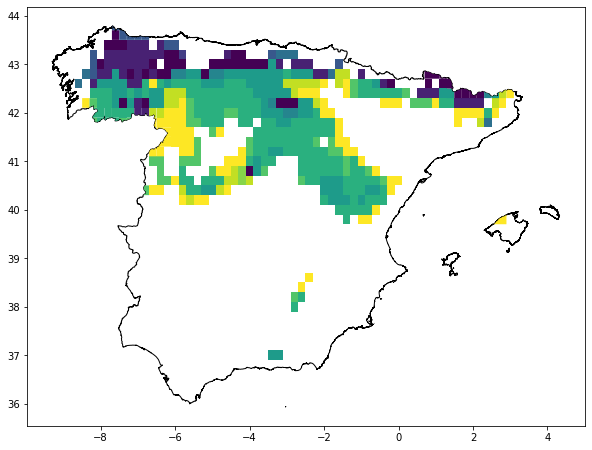

In [52]:
fig, ax = plt.subplots(figsize=(10,10))
spain.plot(ax=ax, color='w', edgecolor='k')
gdf_zone.plot(ax=ax, column='MEDIA')

**Reorganice indicator table**

In [54]:
# Drop NANs
gdf_zone.dropna(subset=['N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1'],  how='all', inplace=True)
gdf_zone.drop(columns=['MEDIA', 'A1B', 'MEDIA_class', 'A1B_class'], inplace=True)
gdf_zone.rename(columns={'A2': 'rcp85', 'B1': 'rcp45', 'A2_class': 'rcp85_class', 'B1_class': 'rcp45_class'}, inplace=True)
gdf_zone.head()

,DENOMINACI,LONG,LAT,geometry,N1971_2000_class,N1971_2000,rcp85_class,rcp85,rcp45_class,rcp45
62,63.0,-3.8,37.0,"POLYGON ((-3.90000 36.90000, -3.90000 37.10000...","DI+1, CI+1, HI+1",12.0,,NaN,,NaN
63,64.0,-3.6,37.0,"POLYGON ((-3.70000 36.90000, -3.70000 37.10000...","DI+1, CI+1, HI+1",12.0,,NaN,,NaN
64,65.0,-3.4,37.0,"POLYGON ((-3.50000 36.90000, -3.50000 37.10000...","DI+1, CI+2, HI-3",6.0,"DI+1, CI+2, HI-3",6.0,"DI+1, CI+2, HI-2",7.0
65,66.0,-3.2,37.0,"POLYGON ((-3.30000 36.90000, -3.30000 37.10000...","DI+1, CI+2, HI-3",6.0,"DI+1, CI+2, HI-2",7.0,"DI+1, CI+2, HI-2",7.0
66,67.0,-3.0,37.0,"POLYGON ((-3.10000 36.90000, -3.10000 37.10000...","DI+1, CI+1, HI-1",11.0,"DI+1, CI+1, HI-1",11.0,"DI+1, CI+1, HI+1",12.0


In [72]:
df_zone = gdf_zone[['DENOMINACI', 'N1971_2000_class','N1971_2000', 'rcp85_class', 'rcp85', 'rcp45_class', 'rcp45']]
df_zone.rename(columns={'N1971_2000_class': 'baseline_class', 'N1971_2000': 'baseline'}, inplace=True)
df_zone.head()

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,DENOMINACI,baseline_class,baseline,rcp85_class,rcp85,rcp45_class,rcp45
62,63.0,"DI+1, CI+1, HI+1",12.0,,NaN,,NaN
63,64.0,"DI+1, CI+1, HI+1",12.0,,NaN,,NaN
64,65.0,"DI+1, CI+2, HI-3",6.0,"DI+1, CI+2, HI-3",6.0,"DI+1, CI+2, HI-2",7.0
65,66.0,"DI+1, CI+2, HI-3",6.0,"DI+1, CI+2, HI-2",7.0,"DI+1, CI+2, HI-2",7.0
66,67.0,"DI+1, CI+1, HI-1",11.0,"DI+1, CI+1, HI-1",11.0,"DI+1, CI+1, HI+1",12.0


In [107]:
df_zone_value = df_zone[['DENOMINACI', 'baseline', 'rcp85', 'rcp45']]
df_zone_value = df_zone_value.melt(id_vars = 'DENOMINACI', var_name='scenario', value_name = "value")
df_zone_class = df_zone[['DENOMINACI', 'baseline_class', 'rcp85_class', 'rcp45_class']]
df_zone_class.rename(columns={'baseline_class': 'baseline', 'rcp85_class': 'rcp85', 'rcp45_class': 'rcp45'}, inplace=True)
df_zone_class = df_zone_class.melt(id_vars = 'DENOMINACI', var_name='scenario', value_name = "class")
df_zone_new = pd.merge(df_zone_value, df_zone_class.drop(columns=['DENOMINACI', 'scenario']), how ='left', left_index=True, right_index=True)
df_zone_new['dataset'] = 'Cambio climático en el viñedo'
df_zone_new['indicator'] = 'Zonas de alto potencial climático'
df_zone_new['year'] = ['1971-2000']*len(df_zone)+['2021-2050']*len(df_zone)*2
df_zone_new['unit'] = ''
df_zone_new = df_zone_new[['DENOMINACI', 'dataset', 'indicator', 'scenario', 'value', 'class', 'year', 'unit']]
df_zone_new.head()

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,DENOMINACI,dataset,indicator,scenario,value,class,year,unit
0,63.0,Cambio climático en el viñedo,Zonas de alto potencial climático,baseline,12.0,"DI+1, CI+1, HI+1",1971-2000,
1,64.0,Cambio climático en el viñedo,Zonas de alto potencial climático,baseline,12.0,"DI+1, CI+1, HI+1",1971-2000,
2,65.0,Cambio climático en el viñedo,Zonas de alto potencial climático,baseline,6.0,"DI+1, CI+2, HI-3",1971-2000,
3,66.0,Cambio climático en el viñedo,Zonas de alto potencial climático,baseline,6.0,"DI+1, CI+2, HI-3",1971-2000,
4,67.0,Cambio climático en el viñedo,Zonas de alto potencial climático,baseline,11.0,"DI+1, CI+1, HI-1",1971-2000,


**Save tables**

In [108]:
df_zone_new.to_csv(f'../../datasets/processed/zonas_alto_potencial_climático_viñedos.csv', index = False)

## Olas de calor

In [55]:
gdf_vinos = gpd.read_file('../../datasets/raw/georegions/Vinos/calidaddiferenciada_vinos_tcm30-376469/CalidadDiferenciada_Vinos.shp')

<AxesSubplot:>

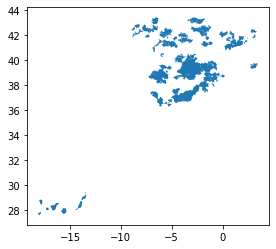

In [56]:
gdf_vinos.plot()